In [1]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *

# qiskit-ibmq-provider has been deprecated.
# Please see the Migration Guides in https://ibm.biz/provider_migration_guide for more detail.
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

# Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum")

# Invoke a primitive. For more details see https://qiskit.org/documentation/partners/qiskit_ibm_runtime/tutorials.html
# result = Sampler("ibmq_qasm_simulator").run(circuits).result()

qiskit_runtime_service.__init__:INFO:2024-01-09 16:51:11,522: Default instance: ibm-q/open/main


In [2]:
import qiskit.tools.jupyter

%qiskit_version_table

In [3]:
# useful additional packages
import matplotlib.pyplot as plt
import numpy as np
import pylab

import networkx as nx

from qiskit.tools.visualization import plot_histogram
from qiskit.circuit.library import TwoLocal
from qiskit_optimization.applications import Maxcut, Tsp
from qiskit_algorithms import SamplingVQE, NumPyMinimumEigensolver
from qiskit_algorithms.optimizers import SPSA, COBYLA
from qiskit_algorithms.utils import algorithm_globals
from qiskit.primitives import Sampler
from qiskit_optimization.algorithms import MinimumEigenOptimizer

from qiskit_optimization.converters import QuadraticProgramToQubo

from qiskit.circuit import QuantumCircuit, Parameter, ParameterVector

from itertools import permutations #per brutal approches TSP

In [4]:
#draw a graph by coloring the nodes
def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

### TSP

In [5]:
counts=[]
params=[]
values=[]
mddict=[]
def store_intermediate_result(count, parameters, value, step):
    counts.append(count)
    params.append(parameters)
    values.append(value)
    mddict.append(step)
  #  nonso.append(nnso)

In [6]:
### Proviamoo a definire un grafo con 4 vertici

In [7]:
n = 4  # Number of nodes in graph
G_4 = nx.Graph()
G_4.add_nodes_from(np.arange(0, n, 1))
elist = [(0, 1, 1.0), (0, 2, 1.0), (0, 3, 3.0), (1, 2, 3.0), (1, 3, 1.0), (2,3,1)]
# tuple is (i,j,weight) where (i,j) is the edge
G_4.add_weighted_edges_from(elist)

colors = ["r" for node in G_4.nodes()]
pos = nx.spring_layout(G_4)

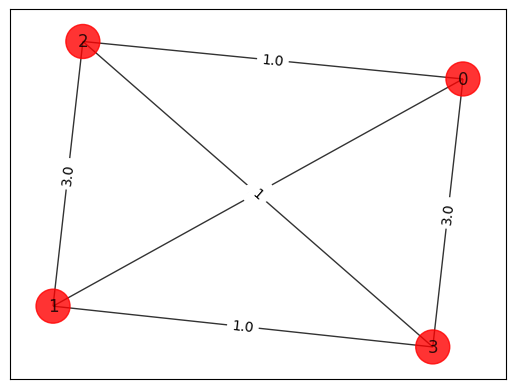

In [8]:
draw_graph(G_4, colors, pos)

In [9]:
tsp4 = Tsp(G_4)

In [10]:
adj_matrix1 = nx.to_numpy_array(tsp4.graph)

In [11]:
qp_tsp4 = tsp4.to_quadratic_program()
#print(qp_tsp4.prettyprint())

In [12]:
qp2qubo_tsp4 = QuadraticProgramToQubo()
qubo_tsp4 = qp2qubo_tsp4.convert(qp_tsp4)
#print(str(qubo.prettyprint()))
qubitOp_tsp4, offset = qubo_tsp4.to_ising()
#print("Offset:", offset)
#print("Ising Hamiltonian:")
#print(str(qubitOp_tsp1.to_matrix().real))
#print(str(qubitOp_tsp4))

In [13]:
# Making the Hamiltonian in its full form and getting the lowest eigenvalue and eigenvector
ee = NumPyMinimumEigensolver()
result_tsp_1 = ee.compute_minimum_eigenvalue(qubitOp_tsp4)

print("energy:", result_tsp_1.eigenvalue.real)
print("tsp objective:", result_tsp_1.eigenvalue.real + offset)
x_tsp = tsp4.sample_most_likely(result_tsp_1.eigenstate)
print("feasible:", qubo_tsp4.is_feasible(x_tsp))
z_tsp = tsp4.interpret(x_tsp)
print("solution:", z_tsp)
print("solution objective:", tsp4.tsp_value(z_tsp, adj_matrix1))

energy: -1312.0
tsp objective: 4.0
feasible: True
solution: [0, 1, 3, 2]
solution objective: 4.0


In [14]:
algorithm_globals.random_seed = 123
seed = 10598

energy: -1111.6675572719332
time: 965.0428359508514
feasible: False


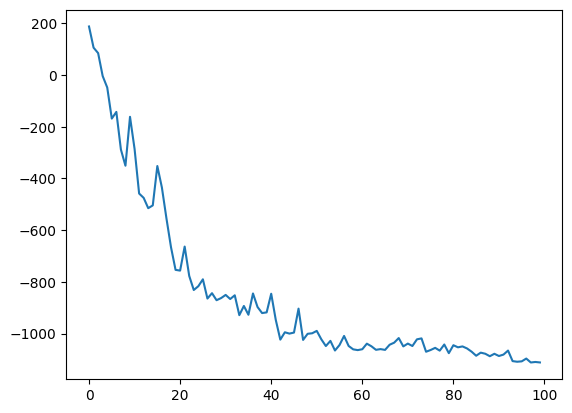

In [44]:
# construct SamplingVQE with callback
counts=[]
params=[]
values=[]
mddict=[]
optimizer = COBYLA(maxiter=100)
ry_clb = TwoLocal(qubitOp_tsp4.num_qubits, "ry", "cz", reps=2, entanglement="circular", skip_final_rotation_layer=True)
vqe_clb = SamplingVQE(sampler=Sampler(), ansatz=ry_clb, optimizer=optimizer, callback=store_intermediate_result)
# run SamplingVQE
result_clb = vqe_clb.compute_minimum_eigenvalue(qubitOp_tsp4)
pylab.plot( values)
print("energy:", result_clb.eigenvalue.real)
print("time:", result_clb.optimizer_time)
x_clb = tsp4.sample_most_likely(result_clb.eigenstate)
print("feasible:", qp_tsp4.is_feasible(x_clb))
if  qp_tsp4.is_feasible(x_clb)==True:
    z_clb = tsp4.interpret(x_clb)
    print("solution:", z_clb)
    print("solution objective:", tsp4.tsp_value(z_clb, adj_matrix1))

energy: -1017.7774836127044
time: 990.8344688415527
feasible: False


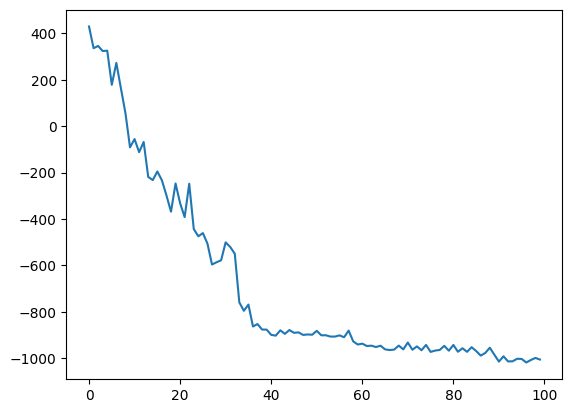

In [43]:
# construct SamplingVQE with callback
counts=[]
params=[]
values=[]
mddict=[]
optimizer = COBYLA(maxiter=100)
ry_clb = TwoLocal(qubitOp_tsp4.num_qubits, "ry", "cz", reps=1, entanglement="full", skip_final_rotation_layer=False)
vqe_clb = SamplingVQE(sampler=Sampler(), ansatz=ry_clb, optimizer=optimizer, callback=store_intermediate_result)
# run SamplingVQE
result_clb = vqe_clb.compute_minimum_eigenvalue(qubitOp_tsp4)
pylab.plot( values)
print("energy:", result_clb.eigenvalue.real)
print("time:", result_clb.optimizer_time)
x_clb = tsp4.sample_most_likely(result_clb.eigenstate)
print("feasible:", qp_tsp4.is_feasible(x_clb))
if  qp_tsp4.is_feasible(x_clb)==True:
    z_clb = tsp4.interpret(x_clb)
    print("solution:", z_clb)
    print("solution objective:", tsp4.tsp_value(z_clb, adj_matrix1))

energy: -844.005318499288
time: 1050.0362169742584
feasible: False


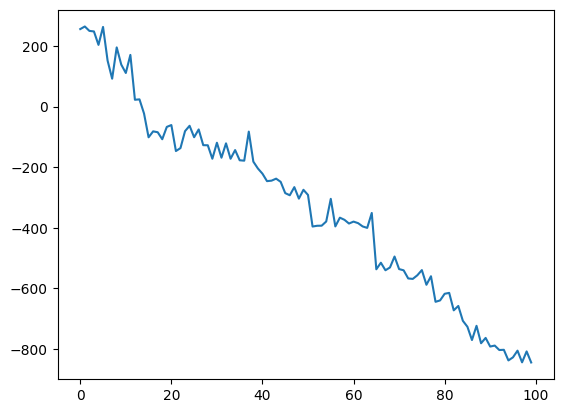

In [42]:
# construct SamplingVQE with callback
counts=[]
params=[]
values=[]
mddict=[]
optimizer = COBYLA(maxiter=100)
ry_clb = TwoLocal(qubitOp_tsp4.num_qubits, "ry", "cz", reps=3, entanglement="full")
vqe_clb = SamplingVQE(sampler=Sampler(), ansatz=ry_clb, optimizer=optimizer, callback=store_intermediate_result)
# run SamplingVQE
result_clb = vqe_clb.compute_minimum_eigenvalue(qubitOp_tsp4)
pylab.plot( values)
print("energy:", result_clb.eigenvalue.real)
print("time:", result_clb.optimizer_time)
x_clb = tsp4.sample_most_likely(result_clb.eigenstate)
print("feasible:", qp_tsp4.is_feasible(x_clb))
if  qp_tsp4.is_feasible(x_clb)==True:
    z_clb = tsp4.interpret(x_clb)
    print("solution:", z_clb)
    print("solution objective:", tsp4.tsp_value(z_clb, adj_matrix1))

energy: -940.2102119991174
time: 1047.7687454223633
feasible: False


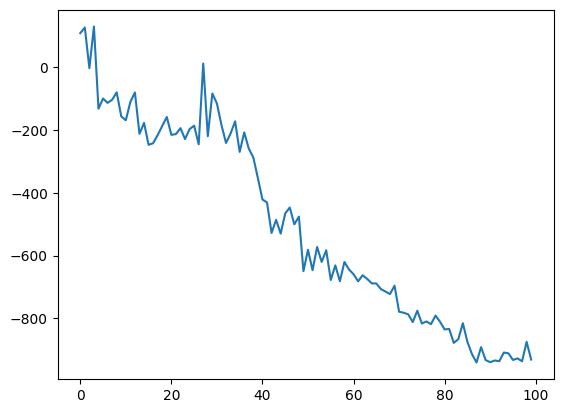

In [41]:
# construct SamplingVQE with callback
counts=[]
params=[]
values=[]
mddict=[]
optimizer = COBYLA(maxiter=100)
ry_clb = TwoLocal(qubitOp_tsp4.num_qubits, "ry", "cz", reps=2, entanglement="full")
vqe_clb = SamplingVQE(sampler=Sampler(), ansatz=ry_clb, optimizer=optimizer, callback=store_intermediate_result)
# run SamplingVQE
result_clb = vqe_clb.compute_minimum_eigenvalue(qubitOp_tsp4)
pylab.plot( values)
print("energy:", result_clb.eigenvalue.real)
print("time:", result_clb.optimizer_time)
x_clb = tsp4.sample_most_likely(result_clb.eigenstate)
print("feasible:", qp_tsp4.is_feasible(x_clb))
if  qp_tsp4.is_feasible(x_clb)==True:
    z_clb = tsp4.interpret(x_clb)
    print("solution:", z_clb)
    print("solution objective:", tsp4.tsp_value(z_clb, adj_matrix1))

energy: -987.5841952320028
time: 1032.7659182548523
feasible: False


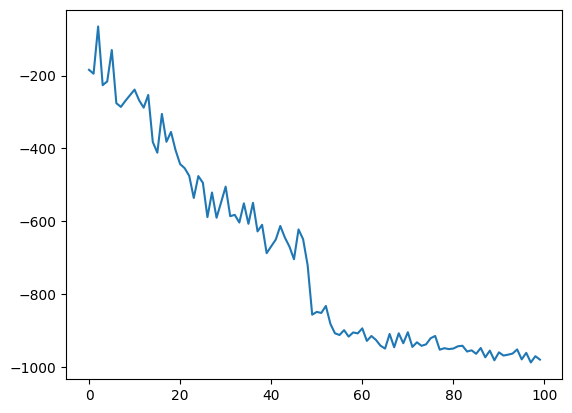

In [40]:
# construct SamplingVQE with callback
counts=[]
params=[]
values=[]
mddict=[]
optimizer = COBYLA(maxiter=100)
ry_clb = TwoLocal(qubitOp_tsp4.num_qubits, "ry", "cz", reps=2, entanglement="full")
vqe_clb = SamplingVQE(sampler=Sampler(), ansatz=ry_clb, optimizer=optimizer, callback=store_intermediate_result)
# run SamplingVQE
result_clb = vqe_clb.compute_minimum_eigenvalue(qubitOp_tsp4)
pylab.plot( values)
print("energy:", result_clb.eigenvalue.real)
print("time:", result_clb.optimizer_time)
x_clb = tsp4.sample_most_likely(result_clb.eigenstate)
print("feasible:", qp_tsp4.is_feasible(x_clb))
if  qp_tsp4.is_feasible(x_clb)==True:
    z_clb = tsp4.interpret(x_clb)
    print("solution:", z_clb)
    print("solution objective:", tsp4.tsp_value(z_clb, adj_matrix1))

energy: -1050.2228902497163
time: 2725.1093060970306
feasible: False


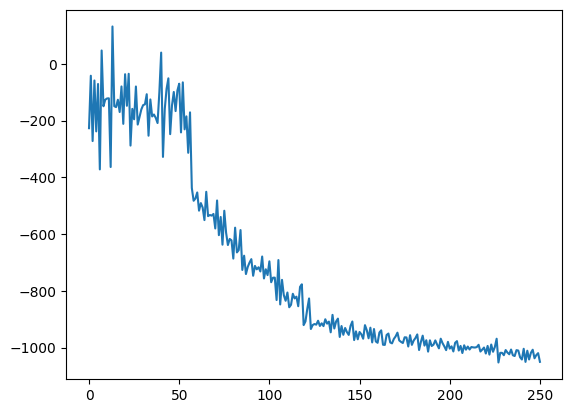

In [39]:
# construct SamplingVQE with callback
counts=[]
params=[]
values=[]
mddict=[]
optimizer = SPSA(maxiter=100)
ry_clb = TwoLocal(qubitOp_tsp4.num_qubits, "ry", "cz", reps=2, entanglement="full")
vqe_clb = SamplingVQE(sampler=Sampler(), ansatz=ry_clb, optimizer=optimizer, callback=store_intermediate_result)
# run SamplingVQE
result_clb = vqe_clb.compute_minimum_eigenvalue(qubitOp_tsp4)
pylab.plot( values)
print("energy:", result_clb.eigenvalue.real)
print("time:", result_clb.optimizer_time)
x_clb = tsp4.sample_most_likely(result_clb.eigenstate)
print("feasible:", qp_tsp4.is_feasible(x_clb))
if  qp_tsp4.is_feasible(x_clb)==True:
    z_clb = tsp4.interpret(x_clb)
    print("solution:", z_clb)
    print("solution objective:", tsp4.tsp_value(z_clb, adj_matrix1))

energy: -951.1799163278296
time: 2583.8299465179443
feasible: False


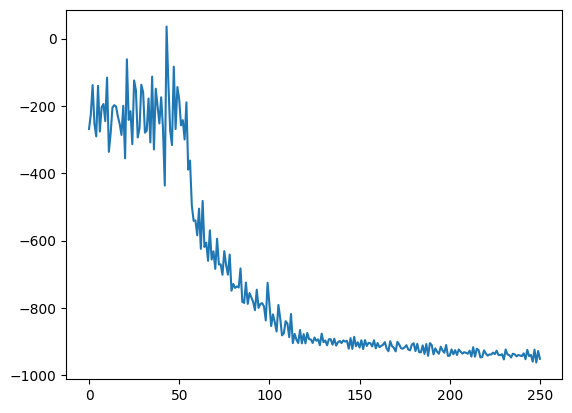

In [38]:
# construct SamplingVQE with callback
counts=[]
params=[]
values=[]
mddict=[]
optimizer = SPSA(maxiter=100)
ry_clb = TwoLocal(qubitOp_tsp4.num_qubits, "ry", "cz", reps=1, entanglement="full")
vqe_clb = SamplingVQE(sampler=Sampler(), ansatz=ry_clb, optimizer=optimizer, callback=store_intermediate_result)
# run SamplingVQE
result_clb = vqe_clb.compute_minimum_eigenvalue(qubitOp_tsp4)
pylab.plot( values)
print("energy:", result_clb.eigenvalue.real)
print("time:", result_clb.optimizer_time)
x_clb = tsp4.sample_most_likely(result_clb.eigenstate)
print("feasible:", qp_tsp4.is_feasible(x_clb))
if  qp_tsp4.is_feasible(x_clb)==True:
    z_clb = tsp4.interpret(x_clb)
    print("solution:", z_clb)
    print("solution objective:", tsp4.tsp_value(z_clb, adj_matrix1))

energy: -967.2830006355501
time: 2732.897542953491
feasible: False


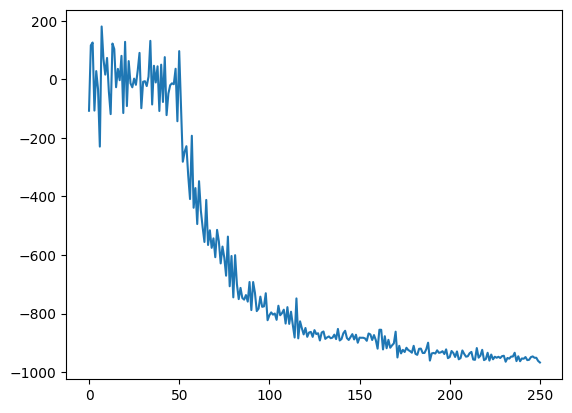

In [37]:
# construct SamplingVQE with callback
counts=[]
params=[]
values=[]
mddict=[]
optimizer = SPSA(maxiter=100)
ry_clb = TwoLocal(qubitOp_tsp4.num_qubits, "ry", "cz", reps=2, entanglement="full")
vqe_clb = SamplingVQE(sampler=Sampler(), ansatz=ry_clb, optimizer=optimizer, callback=store_intermediate_result)
# run SamplingVQE
result_clb = vqe_clb.compute_minimum_eigenvalue(qubitOp_tsp4)
pylab.plot( values)
print("energy:", result_clb.eigenvalue.real)
print("time:", result_clb.optimizer_time)
x_clb = tsp4.sample_most_likely(result_clb.eigenstate)
print("feasible:", qp_tsp4.is_feasible(x_clb))
if  qp_tsp4.is_feasible(x_clb)==True:
    z_clb = tsp4.interpret(x_clb)
    print("solution:", z_clb)
    print("solution objective:", tsp4.tsp_value(z_clb, adj_matrix1))

energy: -897.0520870070321
time: 1866.0888514518738
feasible: True
solution: [[], [], 0, 1]
solution objective: []


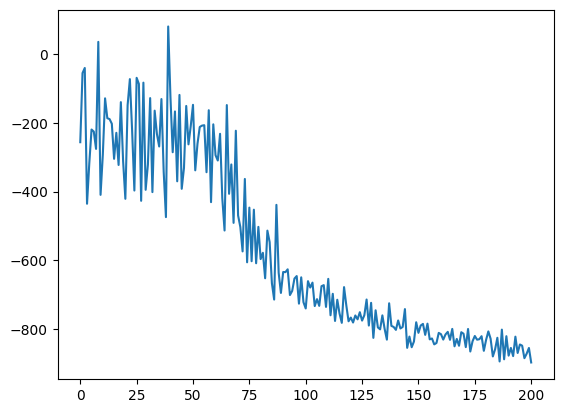

In [ ]:
# construct SamplingVQE with callback
counts=[]
params=[]
values=[]
mddict=[]
optimizer = SPSA(maxiter=75)
ry_clb = TwoLocal(qubitOp_tsp4.num_qubits, "ry", "cz", reps=3, entanglement="linear")
vqe_clb = SamplingVQE(sampler=Sampler(), ansatz=ry_clb, optimizer=optimizer, callback=store_intermediate_result)
# run SamplingVQE
result_clb = vqe_clb.compute_minimum_eigenvalue(qubitOp_tsp4)
pylab.plot( values)
print("energy:", result_clb.eigenvalue.real)
print("time:", result_clb.optimizer_time)
x_clb = tsp4.sample_most_likely(result_clb.eigenstate)
print("feasible:", qp_tsp4.is_feasible(x_clb))
if  qp_tsp4.is_feasible(x_clb)==True:
    z_clb = tsp4.interpret(x_clb)
    print("solution:", z_clb)
    print("solution objective:", tsp4.tsp_value(z_clb, adj_matrix1))

energy: -1299.885415596775
time: 2521.8830411434174
feasible: True
solution: [0, 1, 2, 3]
solution objective: 8.0


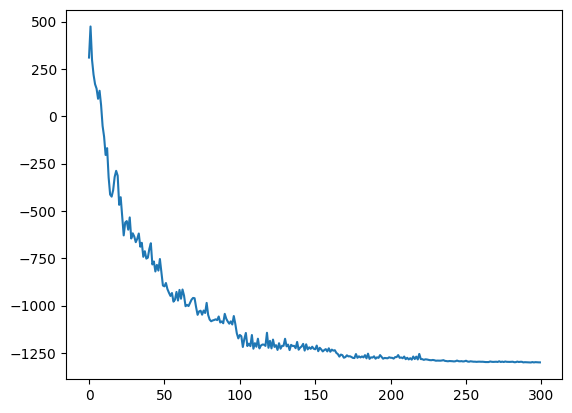

In [36]:
# construct SamplingVQE with callback
counts=[]
params=[]
values=[]
mddict=[]
optimizer = COBYLA(maxiter=300, tol=0.2)
ry_clb = TwoLocal(qubitOp_tsp4.num_qubits, "ry", "cz", reps=2, entanglement="linear")
vqe_clb = SamplingVQE(sampler=Sampler(), ansatz=ry_clb, optimizer=optimizer, callback=store_intermediate_result)
# run SamplingVQE
result_clb = vqe_clb.compute_minimum_eigenvalue(qubitOp_tsp4)
pylab.plot( values)
print("energy:", result_clb.eigenvalue.real)
print("time:", result_clb.optimizer_time)
x_clb = tsp4.sample_most_likely(result_clb.eigenstate)
print("feasible:", qp_tsp4.is_feasible(x_clb))
if  qp_tsp4.is_feasible(x_clb)==True:
    z_clb = tsp4.interpret(x_clb)
    print("solution:", z_clb)
    print("solution objective:", tsp4.tsp_value(z_clb, adj_matrix1))

energy: -1293.7289078365675
time: 2867.3618750572205
feasible: True
solution: [1, 3, 2, 0]
solution objective: 4.0


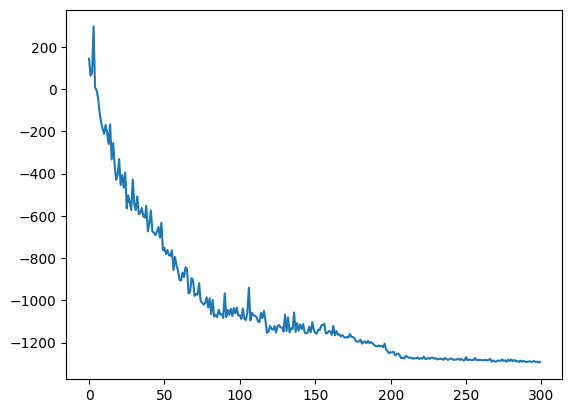

In [35]:
# construct SamplingVQE with callback
counts=[]
params=[]
values=[]
mddict=[]
optimizer = COBYLA(maxiter=300, tol=0.35)
ry_clb = TwoLocal(qubitOp_tsp4.num_qubits, "ry", "cz", reps=2, entanglement="linear")
vqe_clb = SamplingVQE(sampler=Sampler(), ansatz=ry_clb, optimizer=optimizer, callback=store_intermediate_result)
# run SamplingVQE
result_clb = vqe_clb.compute_minimum_eigenvalue(qubitOp_tsp4)
pylab.plot( values)
print("energy:", result_clb.eigenvalue.real)
print("time:", result_clb.optimizer_time)
x_clb = tsp4.sample_most_likely(result_clb.eigenstate)
print("feasible:", qp_tsp4.is_feasible(x_clb))
if  qp_tsp4.is_feasible(x_clb)==True:
    z_clb = tsp4.interpret(x_clb)
    print("solution:", z_clb)
    print("solution objective:", tsp4.tsp_value(z_clb, adj_matrix1))

energy: -1265.441291045527
time: 2191.2169411182404
feasible: True
solution: [2, 0, 1, 3]
solution objective: 4.0


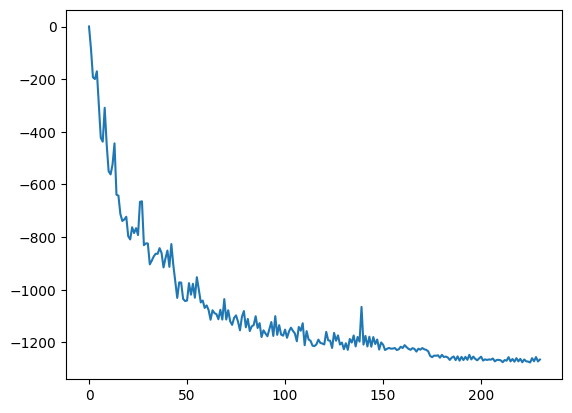

In [34]:
# construct SamplingVQE with callback
counts=[]
params=[]
values=[]
mddict=[]
optimizer = COBYLA(maxiter=300, tol=0.5)
ry_clb = TwoLocal(qubitOp_tsp4.num_qubits, "ry", "cz", reps=2, entanglement="linear")
vqe_clb = SamplingVQE(sampler=Sampler(), ansatz=ry_clb, optimizer=optimizer, callback=store_intermediate_result)
# run SamplingVQE
result_clb = vqe_clb.compute_minimum_eigenvalue(qubitOp_tsp4)
pylab.plot( values)
print("energy:", result_clb.eigenvalue.real)
print("time:", result_clb.optimizer_time)
x_clb = tsp4.sample_most_likely(result_clb.eigenstate)
print("feasible:", qubo_tsp4.is_feasible(x_clb))
if  qp_tsp4.is_feasible(x_clb)==True:
    z_clb = tsp4.interpret(x_clb)
    print("solution:", z_clb)
    print("solution objective:", tsp4.tsp_value(z_clb, adj_matrix1))

energy: -1292.9380312554067
time: 511.9287619590759
feasible: True
solution: [0, 3, 1, 2]
solution objective: 8.0


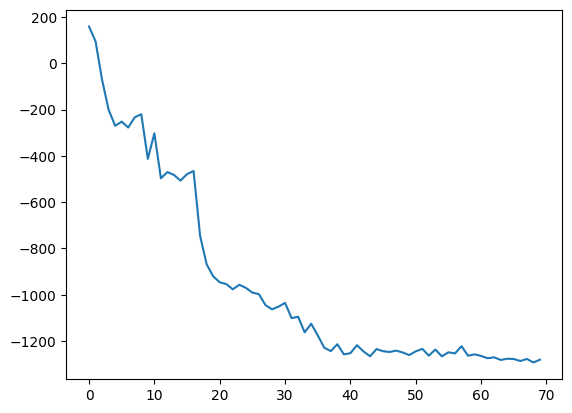

In [33]:
# construct SamplingVQE with callback
counts=[]
params=[]
values=[]
mddict=[]
optimizer = COBYLA(maxiter=70)
ry_clb = TwoLocal(qubitOp_tsp4.num_qubits, "ry", "cz", reps=1, entanglement="full", skip_final_rotation_layer=True)
vqe_clb = SamplingVQE(sampler=Sampler(), ansatz=ry_clb, optimizer=optimizer, callback=store_intermediate_result)
# run SamplingVQE
result_clb = vqe_clb.compute_minimum_eigenvalue(qubitOp_tsp4)
pylab.plot( values)
print("energy:", result_clb.eigenvalue.real)
print("time:", result_clb.optimizer_time)
x_clb = tsp4.sample_most_likely(result_clb.eigenstate)
print("feasible:", qubo_tsp4.is_feasible(x_clb))
if  qp_tsp4.is_feasible(x_clb)==True:
    z_clb = tsp4.interpret(x_clb)
    print("solution:", z_clb)
    print("solution objective:", tsp4.tsp_value(z_clb, adj_matrix1))

energy: -1257.5666169669767
time: 777.5279002189636
feasible: True
solution: [1, 3, 2, 0]
solution objective: 4.0


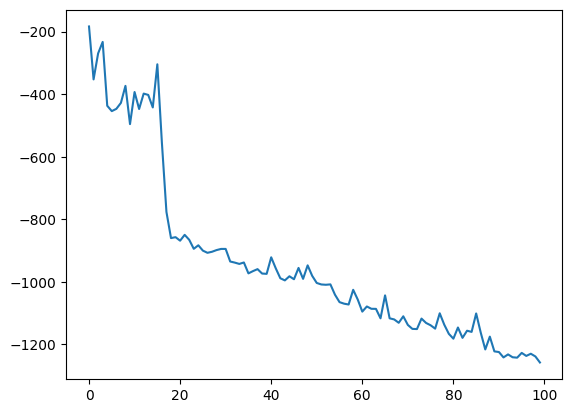

In [32]:
# construct SamplingVQE with callback
counts=[]
params=[]
values=[]
mddict=[]
optimizer = COBYLA(maxiter=100)
ry_clb = TwoLocal(qubitOp_tsp4.num_qubits, "ry", "cz", reps=1, entanglement="full", skip_final_rotation_layer=True)
vqe_clb = SamplingVQE(sampler=Sampler(), ansatz=ry_clb, optimizer=optimizer, callback=store_intermediate_result)
# run SamplingVQE
result_clb = vqe_clb.compute_minimum_eigenvalue(qubitOp_tsp4)
pylab.plot( values)
print("energy:", result_clb.eigenvalue.real)
print("time:", result_clb.optimizer_time)
x_clb = tsp4.sample_most_likely(result_clb.eigenstate)
print("feasible:", qubo_tsp4.is_feasible(x_clb))
if  qp_tsp4.is_feasible(x_clb)==True:
    z_clb = tsp4.interpret(x_clb)
    print("solution:", z_clb)
    print("solution objective:", tsp4.tsp_value(z_clb, adj_matrix1))

energy: -1300.602834337614
time: 772.1809182167053
feasible: True
solution: [1, 3, 2, 0]
solution objective: 4.0


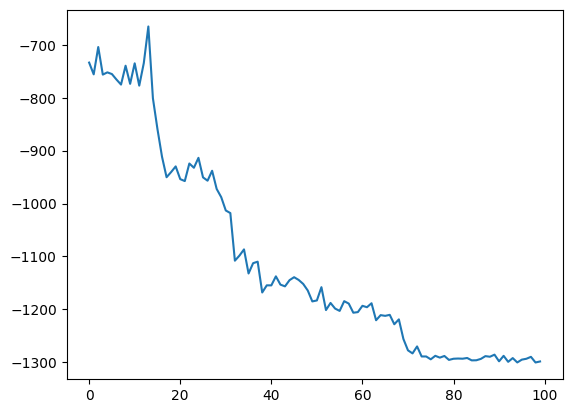

In [18]:
# construct SamplingVQE with callback
counts=[]
params=[]
values=[]
mddict=[]
optimizer = COBYLA(maxiter=100)
ry_clb = TwoLocal(qubitOp_tsp4.num_qubits, "ry", "cz", reps=1, entanglement="full", skip_final_rotation_layer=True)
vqe_clb = SamplingVQE(sampler=Sampler(), ansatz=ry_clb, optimizer=optimizer, callback=store_intermediate_result)
# run SamplingVQE
result_clb = vqe_clb.compute_minimum_eigenvalue(qubitOp_tsp4)
#PLOT RESULT
pylab.plot(values)
print("energy:", result_clb.eigenvalue.real)
print("time:", result_clb.optimizer_time)
x_clb = tsp4.sample_most_likely(result_clb.eigenstate)
print("feasible:", qp_tsp4.is_feasible(x_clb))
if  qp_tsp4.is_feasible(x_clb)==True:
    z_clb = tsp4.interpret(x_clb)
    print("solution:", z_clb)
    print("solution objective:", tsp4.tsp_value(z_clb, adj_matrix1))

/opt/conda/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


energy: -1050.258690839548
time: 1141.6283128261566
feasible: False


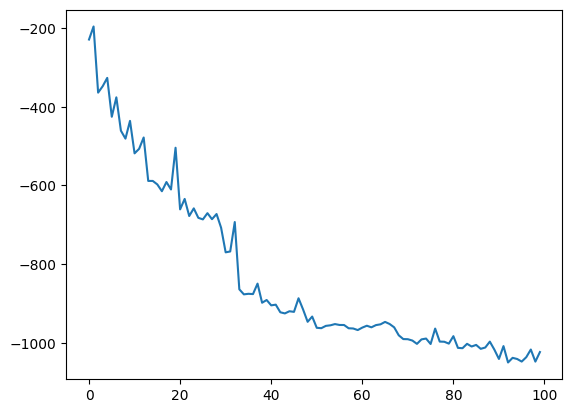

In [16]:
#4
# construct SamplingVQE with callback
counts=[]
params=[]
values=[]
mddict=[]
optimizer = COBYLA(maxiter=100)
ry_clb = TwoLocal(qubitOp_tsp4.num_qubits, "ry", "cz", reps=1, entanglement="full", skip_final_rotation_layer=False)
vqe_clb = SamplingVQE(sampler=Sampler(), ansatz=ry_clb, optimizer=optimizer, callback=store_intermediate_result)
# run SamplingVQE
result_clb = vqe_clb.compute_minimum_eigenvalue(qubitOp_tsp4)
#PLOT RESULT
pylab.plot(values)
print("energy:", result_clb.eigenvalue.real)
print("time:", result_clb.optimizer_time)
x_clb = tsp4.sample_most_likely(result_clb.eigenstate)
print("feasible:", qp_tsp4.is_feasible(x_clb))
if  qp_tsp4.is_feasible(x_clb)==True:
    z_clb = tsp4.interpret(x_clb)
    print("solution:", z_clb)
    print("solution objective:", tsp4.tsp_value(z_clb, adj_matrix1))

energy: -1200.6502438307687
time: 1109.3919270038605
feasible: True
solution: [3, 2, 1, 0]
solution objective: 8.0


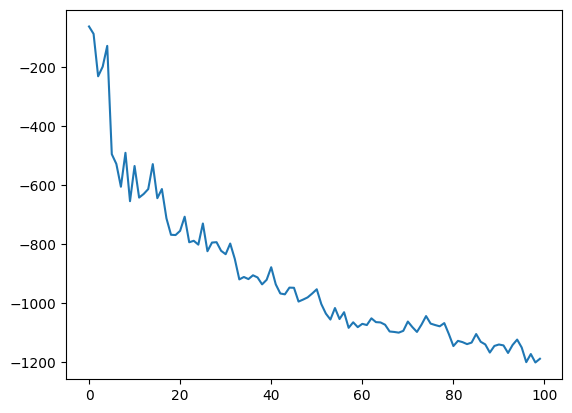

In [17]:
#4
# construct SamplingVQE with callback
counts=[]
params=[]
values=[]
mddict=[]
optimizer = COBYLA(maxiter=100)
ry_clb = TwoLocal(qubitOp_tsp4.num_qubits, "ry", "cz", reps=2, entanglement="circular", skip_final_rotation_layer=True)
vqe_clb = SamplingVQE(sampler=Sampler(), ansatz=ry_clb, optimizer=optimizer, callback=store_intermediate_result)
# run SamplingVQE
result_clb = vqe_clb.compute_minimum_eigenvalue(qubitOp_tsp4)
#PLOT RESULT
pylab.plot(values)
print("energy:", result_clb.eigenvalue.real)
print("time:", result_clb.optimizer_time)
x_clb = tsp4.sample_most_likely(result_clb.eigenstate)
print("feasible:", qp_tsp4.is_feasible(x_clb))
if  qp_tsp4.is_feasible(x_clb)==True:
    z_clb = tsp4.interpret(x_clb)
    print("solution:", z_clb)
    print("solution objective:", tsp4.tsp_value(z_clb, adj_matrix1))

energy: -902.9008107842998
time: 1315.6046872138977
feasible: False


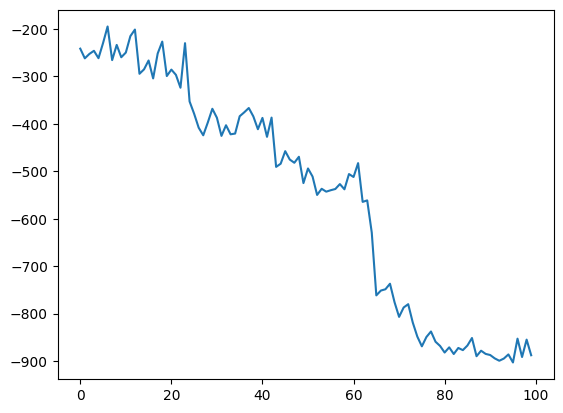

In [19]:
#4
# construct SamplingVQE with callback
counts=[]
params=[]
values=[]
mddict=[]
optimizer = COBYLA(maxiter=100)
ry_clb = TwoLocal(qubitOp_tsp4.num_qubits, "ry", "cz", reps=3, entanglement="full", skip_final_rotation_layer=False)
vqe_clb = SamplingVQE(sampler=Sampler(), ansatz=ry_clb, optimizer=optimizer, callback=store_intermediate_result)
# run SamplingVQE
result_clb = vqe_clb.compute_minimum_eigenvalue(qubitOp_tsp4)
#PLOT RESULT
pylab.plot(values)
print("energy:", result_clb.eigenvalue.real)
print("time:", result_clb.optimizer_time)
x_clb = tsp4.sample_most_likely(result_clb.eigenstate)
print("feasible:", qp_tsp4.is_feasible(x_clb))
if  qp_tsp4.is_feasible(x_clb)==True:
    z_clb = tsp4.interpret(x_clb)
    print("solution:", z_clb)
    print("solution objective:", tsp4.tsp_value(z_clb, adj_matrix1))

energy: -544.7901729486908
time: 1264.100290775299
feasible: False


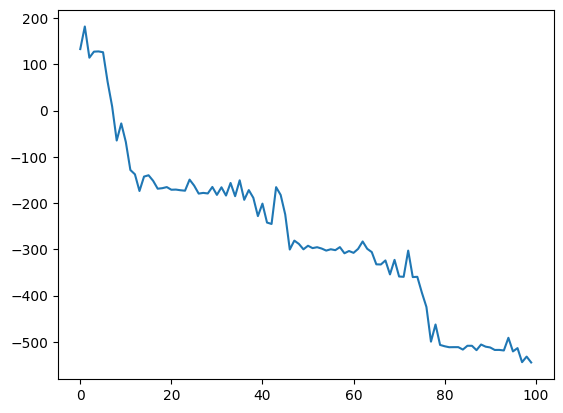

In [20]:
#4
# construct SamplingVQE with callback
counts=[]
params=[]
values=[]
mddict=[]
optimizer = COBYLA(maxiter=100)
ry_clb = TwoLocal(qubitOp_tsp4.num_qubits, ["ry","rz"], "cz", reps=3, entanglement="full", skip_final_rotation_layer=False)
vqe_clb = SamplingVQE(sampler=Sampler(), ansatz=ry_clb, optimizer=optimizer, callback=store_intermediate_result)
# run SamplingVQE
result_clb = vqe_clb.compute_minimum_eigenvalue(qubitOp_tsp4)
#PLOT RESULT
pylab.plot(values)
print("energy:", result_clb.eigenvalue.real)
print("time:", result_clb.optimizer_time)
x_clb = tsp4.sample_most_likely(result_clb.eigenstate)
print("feasible:", qp_tsp4.is_feasible(x_clb))
if  qp_tsp4.is_feasible(x_clb)==True:
    z_clb = tsp4.interpret(x_clb)
    print("solution:", z_clb)
    print("solution objective:", tsp4.tsp_value(z_clb, adj_matrix1))

energy: -829.4773915950514
time: 1263.9453325271606
feasible: False


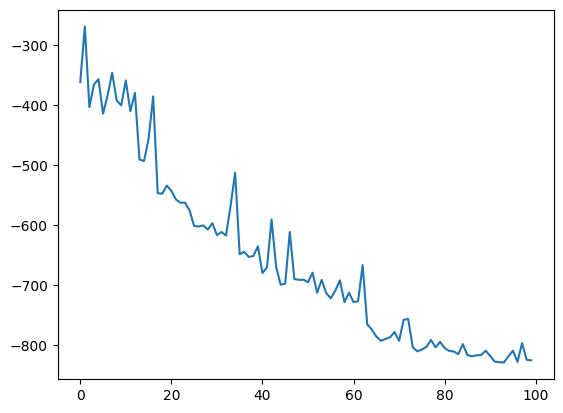

In [21]:
#3
# construct SamplingVQE with callback
counts=[]
params=[]
values=[]
mddict=[]
optimizer = COBYLA(maxiter=100)
ry_clb = TwoLocal(qubitOp_tsp4.num_qubits, ["ry","rz"], "cz", reps=3, entanglement="circular", skip_final_rotation_layer=False)
vqe_clb = SamplingVQE(sampler=Sampler(), ansatz=ry_clb, optimizer=optimizer, callback=store_intermediate_result)
# run SamplingVQE
result_clb = vqe_clb.compute_minimum_eigenvalue(qubitOp_tsp4)
#PLOT RESULT
pylab.plot(values)
print("energy:", result_clb.eigenvalue.real)
print("time:", result_clb.optimizer_time)
x_clb = tsp4.sample_most_likely(result_clb.eigenstate)
print("feasible:", qp_tsp4.is_feasible(x_clb))
if  qp_tsp4.is_feasible(x_clb)==True:
    z_clb = tsp4.interpret(x_clb)
    print("solution:", z_clb)
    print("solution objective:", tsp4.tsp_value(z_clb, adj_matrix1))

energy: -864.9343662245591
time: 1203.6030232906342
feasible: False


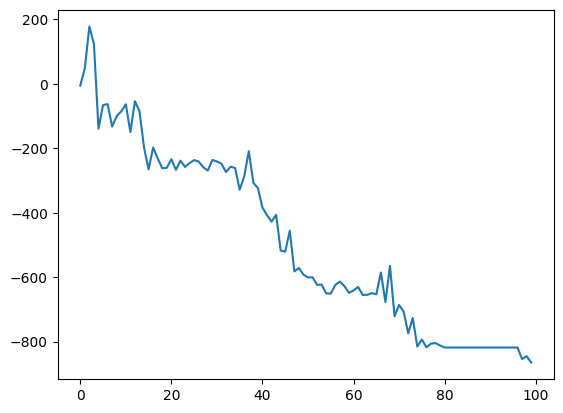

In [22]:
#3
# construct SamplingVQE with callback
counts=[]
params=[]
values=[]
mddict=[]
optimizer = COBYLA(maxiter=100)
ry_clb = TwoLocal(qubitOp_tsp4.num_qubits, ["ry","rz"], "cz", reps=3, entanglement="circular", skip_final_rotation_layer=True)
vqe_clb = SamplingVQE(sampler=Sampler(), ansatz=ry_clb, optimizer=optimizer, callback=store_intermediate_result)
# run SamplingVQE
result_clb = vqe_clb.compute_minimum_eigenvalue(qubitOp_tsp4)
#PLOT RESULT
pylab.plot(values)
print("energy:", result_clb.eigenvalue.real)
print("time:", result_clb.optimizer_time)
x_clb = tsp4.sample_most_likely(result_clb.eigenstate)
print("feasible:", qp_tsp4.is_feasible(x_clb))
if  qp_tsp4.is_feasible(x_clb)==True:
    z_clb = tsp4.interpret(x_clb)
    print("solution:", z_clb)
    print("solution objective:", tsp4.tsp_value(z_clb, adj_matrix1))

energy: -1042.2276233436278
time: 1089.4773461818695
feasible: False


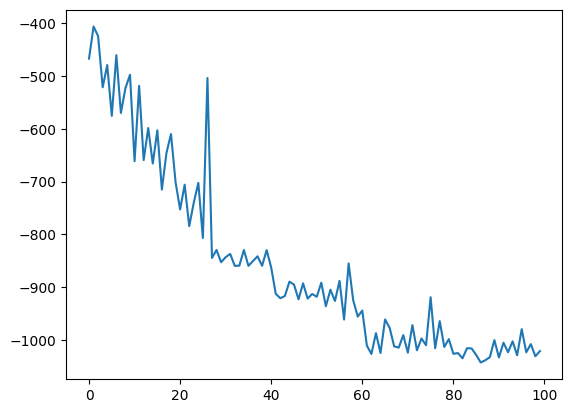

In [23]:
#3
# construct SamplingVQE with callback
counts=[]
params=[]
values=[]
mddict=[]
optimizer = COBYLA(maxiter=100)
ry_clb = TwoLocal(qubitOp_tsp4.num_qubits, "ry", "cz", reps=3, entanglement="circular", skip_final_rotation_layer=True)
vqe_clb = SamplingVQE(sampler=Sampler(), ansatz=ry_clb, optimizer=optimizer, callback=store_intermediate_result)
# run SamplingVQE
result_clb = vqe_clb.compute_minimum_eigenvalue(qubitOp_tsp4)
#PLOT RESULT
pylab.plot(values)
print("energy:", result_clb.eigenvalue.real)
print("time:", result_clb.optimizer_time)
x_clb = tsp4.sample_most_likely(result_clb.eigenstate)
print("feasible:", qp_tsp4.is_feasible(x_clb))
if  qp_tsp4.is_feasible(x_clb)==True:
    z_clb = tsp4.interpret(x_clb)
    print("solution:", z_clb)
    print("solution objective:", tsp4.tsp_value(z_clb, adj_matrix1))

energy: -940.1315428947462
time: 1134.1234967708588
feasible: False


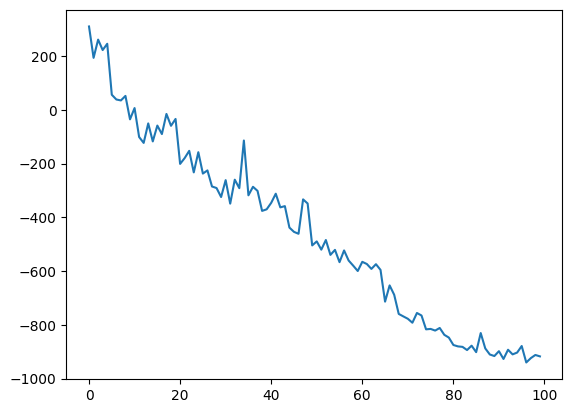

In [24]:
#3
# construct SamplingVQE with callback
counts=[]
params=[]
values=[]
mddict=[]
optimizer = COBYLA(maxiter=100)
ry_clb = TwoLocal(qubitOp_tsp4.num_qubits, "ry", "cz", reps=3, entanglement="circular", skip_final_rotation_layer=False)
vqe_clb = SamplingVQE(sampler=Sampler(), ansatz=ry_clb, optimizer=optimizer, callback=store_intermediate_result)
# run SamplingVQE
result_clb = vqe_clb.compute_minimum_eigenvalue(qubitOp_tsp4)
#PLOT RESULT
pylab.plot(values)
print("energy:", result_clb.eigenvalue.real)
print("time:", result_clb.optimizer_time)
x_clb = tsp4.sample_most_likely(result_clb.eigenstate)
print("feasible:", qp_tsp4.is_feasible(x_clb))
if  qp_tsp4.is_feasible(x_clb)==True:
    z_clb = tsp4.interpret(x_clb)
    print("solution:", z_clb)
    print("solution objective:", tsp4.tsp_value(z_clb, adj_matrix1))


   Return from subroutine COBYLA because the MAXFUN limit has been reached.

   NFVALS =  400   F =-1.311016E+03    MAXCV = 0.000000E+00
   X =-2.370370E+00  -7.215177E-02  -3.147154E+00  -3.144173E+00  -3.199680E+00
       2.364901E-03  -3.133758E+00  -4.884624E-02  -3.061513E+00   3.431241E-02
      -6.281253E+00  -4.042270E-02   6.833760E-02   3.150587E+00   6.270906E+00
      -2.827524E-02   5.490815E+00   6.215782E+00  -3.152640E+00   3.112504E+00
      -3.100000E+00   3.174789E+00   3.149275E+00   6.249811E+00  -3.172042E+00
       4.653576E-02  -2.053225E-02   3.090693E+00   6.745960E-02   3.147417E+00
      -3.126006E+00   6.303802E+00
energy: -1311.015584849393
time: 2517.6895837783813
feasible: True
solution: [0, 1, 3, 2]
solution objective: 4.0


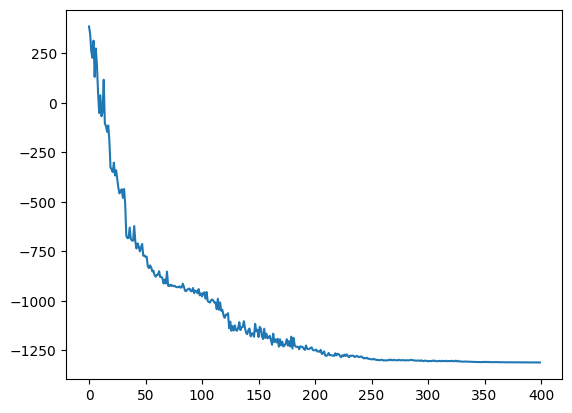

In [25]:
#1
# construct SamplingVQE with callback
counts=[]
params=[]
values=[]
mddict=[]
optimizer = COBYLA(maxiter=400, disp=True)
ry_clb = TwoLocal(qubitOp_tsp4.num_qubits, "ry", "cz", reps=1, entanglement="full", skip_final_rotation_layer=False)
vqe_clb = SamplingVQE(sampler=Sampler(), ansatz=ry_clb, optimizer=optimizer, callback=store_intermediate_result)
# run SamplingVQE
result_clb = vqe_clb.compute_minimum_eigenvalue(qubitOp_tsp4)
#PLOT RESULT
pylab.plot(values)
print("energy:", result_clb.eigenvalue.real)
print("time:", result_clb.optimizer_time)
x_clb = tsp4.sample_most_likely(result_clb.eigenstate)
print("feasible:", qp_tsp4.is_feasible(x_clb))
if  qp_tsp4.is_feasible(x_clb)==True:
    z_clb = tsp4.interpret(x_clb)
    print("solution:", z_clb)
    print("solution objective:", tsp4.tsp_value(z_clb, adj_matrix1))

energy: -972.6804830045689
time: 983.0108826160431
feasible: False


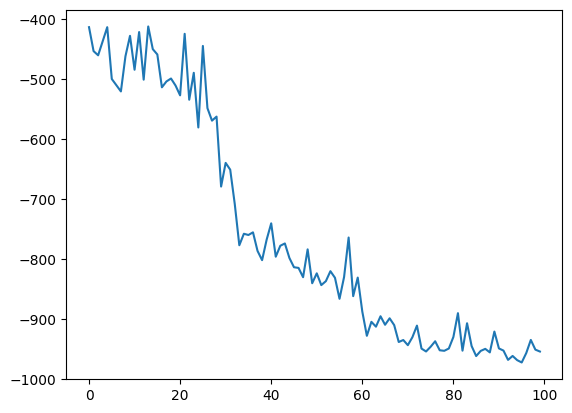

In [45]:
# construct SamplingVQE with callback
counts=[]
params=[]
values=[]
mddict=[]
optimizer = COBYLA(maxiter=100)
ry_clb = TwoLocal(qubitOp_tsp4.num_qubits, "ry", "cz", reps=3, entanglement="circular", skip_final_rotation_layer=True)
vqe_clb = SamplingVQE(sampler=Sampler(), ansatz=ry_clb, optimizer=optimizer, callback=store_intermediate_result)
# run SamplingVQE
result_clb = vqe_clb.compute_minimum_eigenvalue(qubitOp_tsp4)
#PLOT RESULT
pylab.plot(values)
print("energy:", result_clb.eigenvalue.real)
print("time:", result_clb.optimizer_time)
x_clb = tsp4.sample_most_likely(result_clb.eigenstate)
print("feasible:", qp_tsp4.is_feasible(x_clb))
if  qp_tsp4.is_feasible(x_clb)==True:
    z_clb = tsp4.interpret(x_clb)
    print("solution:", z_clb)
    print("solution objective:", tsp4.tsp_value(z_clb, adj_matrix1))

energy: -1262.0964769951952
time: 1462.753277540207
feasible: True
solution: [2, 1, 3, 0]
solution objective: 8.0


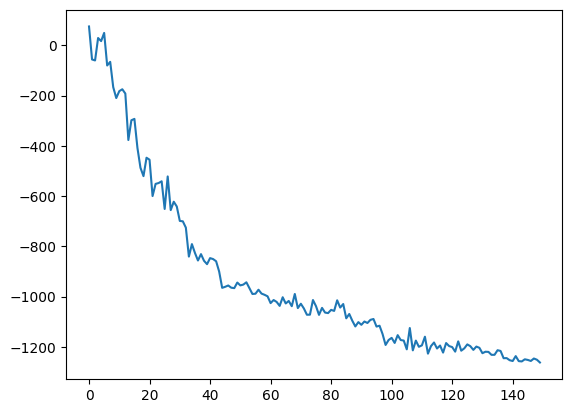

In [46]:
# construct SamplingVQE with callback
counts=[]
params=[]
values=[]
mddict=[]
optimizer = COBYLA(maxiter=150)
ry_clb = TwoLocal(qubitOp_tsp4.num_qubits, "ry", "cz", reps=2, entanglement="circular", skip_final_rotation_layer=True)
vqe_clb = SamplingVQE(sampler=Sampler(), ansatz=ry_clb, optimizer=optimizer, callback=store_intermediate_result)
# run SamplingVQE
result_clb = vqe_clb.compute_minimum_eigenvalue(qubitOp_tsp4)
#PLOT RESULT
pylab.plot(values)
print("energy:", result_clb.eigenvalue.real)
print("time:", result_clb.optimizer_time)
x_clb = tsp4.sample_most_likely(result_clb.eigenstate)
print("feasible:", qp_tsp4.is_feasible(x_clb))

if  qp_tsp4.is_feasible(x_clb)==True:
    z_clb = tsp4.interpret(x_clb)
    print("solution:", z_clb)
    print("solution objective:", tsp4.tsp_value(z_clb, adj_matrix1))

energy: -1303.0811213876318
time: 2243.4520008563995
feasible: True
solution: [3, 0, 2, 1]
solution objective: 8.0


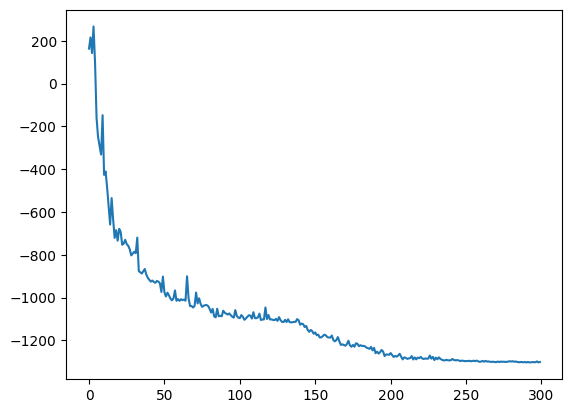

In [26]:
# construct SamplingVQE with callback
counts=[]
params=[]
values=[]
mddict=[]
optimizer = COBYLA(maxiter=300)
ry_clb = TwoLocal(qubitOp_tsp4.num_qubits, "ry", "cz", reps=2, entanglement="circular", skip_final_rotation_layer=True)
vqe_clb = SamplingVQE(sampler=Sampler(), ansatz=ry_clb, optimizer=optimizer, callback=store_intermediate_result)
# run SamplingVQE
result_clb = vqe_clb.compute_minimum_eigenvalue(qubitOp_tsp4)
#PLOT RESULT
pylab.plot(values)
print("energy:", result_clb.eigenvalue.real)
print("time:", result_clb.optimizer_time)
x_clb = tsp4.sample_most_likely(result_clb.eigenstate)
print("feasible:", qp_tsp4.is_feasible(x_clb))
if  qp_tsp4.is_feasible(x_clb)==True:
    z_clb = tsp4.interpret(x_clb)
    print("solution:", z_clb)
    print("solution objective:", tsp4.tsp_value(z_clb, adj_matrix1))

energy: -1250.0775756542873
time: 647.1986014842987
feasible: True
solution: [2, 0, 3, 1]
solution objective: 8.0


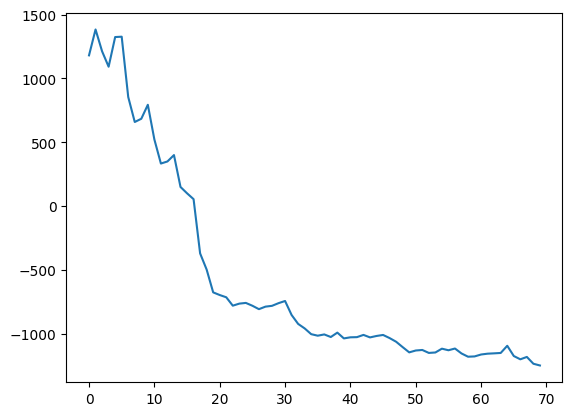

In [27]:
# construct SamplingVQE with callback
counts=[]
params=[]
values=[]
mddict=[]
optimizer = COBYLA(maxiter=70)
ry_clb = TwoLocal(qubitOp_tsp4.num_qubits, "ry", "cz", reps=1, entanglement="full", skip_final_rotation_layer=True)
vqe_clb = SamplingVQE(sampler=Sampler(), ansatz=ry_clb, optimizer=optimizer, callback=store_intermediate_result)
# run SamplingVQE
result_clb = vqe_clb.compute_minimum_eigenvalue(qubitOp_tsp4)
#PLOT RESULT
pylab.plot(values)
print("energy:", result_clb.eigenvalue.real)
print("time:", result_clb.optimizer_time)
x_clb = tsp4.sample_most_likely(result_clb.eigenstate)
print("feasible:", qp_tsp4.is_feasible(x_clb))
if  qp_tsp4.is_feasible(x_clb)==True:
    z_clb = tsp4.interpret(x_clb)
    print("solution:", z_clb)
    print("solution objective:", tsp4.tsp_value(z_clb, adj_matrix1))

energy: -1166.9927410957703
time: 704.0805473327637
feasible: False


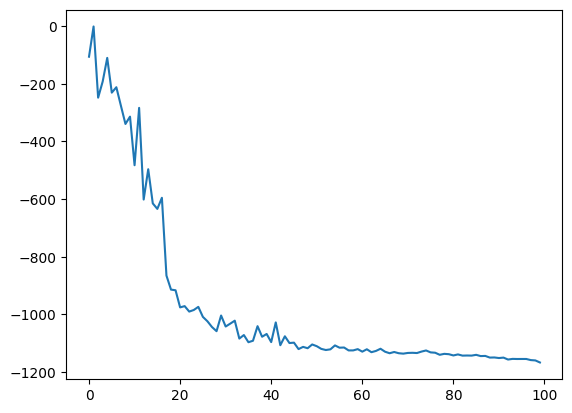

In [28]:
# construct SamplingVQE with callback
counts=[]
params=[]
values=[]
mddict=[]
optimizer = COBYLA(maxiter=100)
ry_clb = TwoLocal(qubitOp_tsp4.num_qubits, "ry", "cz", reps=1, entanglement="full", skip_final_rotation_layer=True)
vqe_clb = SamplingVQE(sampler=Sampler(), ansatz=ry_clb, optimizer=optimizer, callback=store_intermediate_result)
# run SamplingVQE
result_clb = vqe_clb.compute_minimum_eigenvalue(qubitOp_tsp4)
#PLOT RESULT
pylab.plot(values)
print("energy:", result_clb.eigenvalue.real)
print("time:", result_clb.optimizer_time)
x_clb = tsp4.sample_most_likely(result_clb.eigenstate)
print("feasible:", qp_tsp4.is_feasible(x_clb))
if  qp_tsp4.is_feasible(x_clb)==True:
    z_clb = tsp4.interpret(x_clb)
    print("solution:", z_clb)
    print("solution objective:", tsp4.tsp_value(z_clb, adj_matrix1))

energy: -1307.4750146001286
time: 788.0665435791016
feasible: True
solution: [2, 3, 0, 1]
solution objective: 8.0


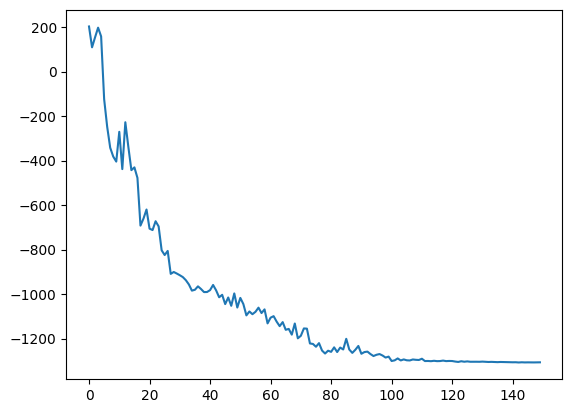

In [29]:
# construct SamplingVQE with callback
counts=[]
params=[]
values=[]
mddict=[]
optimizer = COBYLA(maxiter=150)
ry_clb = TwoLocal(qubitOp_tsp4.num_qubits, "ry", "cz", reps=1, entanglement="full", skip_final_rotation_layer=True)
vqe_clb = SamplingVQE(sampler=Sampler(), ansatz=ry_clb, optimizer=optimizer, callback=store_intermediate_result)
# run SamplingVQE
result_clb = vqe_clb.compute_minimum_eigenvalue(qubitOp_tsp4)
#PLOT RESULT
pylab.plot(values)
print("energy:", result_clb.eigenvalue.real)
print("time:", result_clb.optimizer_time)
x_clb = tsp4.sample_most_likely(result_clb.eigenstate)
print("feasible:", qp_tsp4.is_feasible(x_clb))
if  qp_tsp4.is_feasible(x_clb)==True:
    z_clb = tsp4.interpret(x_clb)
    print("solution:", z_clb)
    print("solution objective:", tsp4.tsp_value(z_clb, adj_matrix1))

energy: -979.5309671606551
time: 764.6590118408203
feasible: False


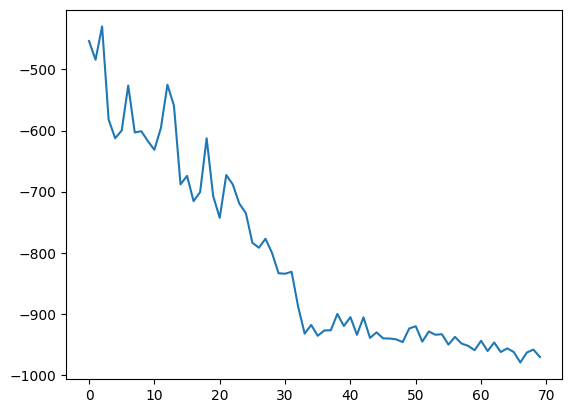

In [30]:
# construct SamplingVQE with callback
counts=[]
params=[]
values=[]
mddict=[]
optimizer = COBYLA(maxiter=70)
ry_clb = TwoLocal(qubitOp_tsp4.num_qubits, "ry", "cz", reps=2, entanglement="full", skip_final_rotation_layer=True)
vqe_clb = SamplingVQE(sampler=Sampler(), ansatz=ry_clb, optimizer=optimizer, callback=store_intermediate_result)
# run SamplingVQE
result_clb = vqe_clb.compute_minimum_eigenvalue(qubitOp_tsp4)
#PLOT RESULT
pylab.plot(values)
print("energy:", result_clb.eigenvalue.real)
print("time:", result_clb.optimizer_time)
x_clb = tsp4.sample_most_likely(result_clb.eigenstate)
print("feasible:", qp_tsp4.is_feasible(x_clb))
if  qp_tsp4.is_feasible(x_clb)==True:
    z_clb = tsp4.interpret(x_clb)
    print("solution:", z_clb)
    print("solution objective:", tsp4.tsp_value(z_clb, adj_matrix1))

energy: -1034.1746016593913
time: 1132.8927960395813
feasible: True
solution: [3, 0, 1, 2]
solution objective: 8.0


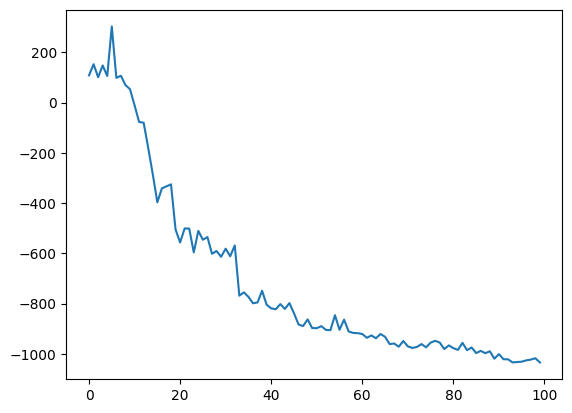

In [31]:
# construct SamplingVQE with callback
counts=[]
params=[]
values=[]
mddict=[]
optimizer = COBYLA(maxiter=100)
ry_clb = TwoLocal(qubitOp_tsp4.num_qubits, "ry", "cz", reps=2, entanglement="full", skip_final_rotation_layer=True)
vqe_clb = SamplingVQE(sampler=Sampler(), ansatz=ry_clb, optimizer=optimizer, callback=store_intermediate_result)
# run SamplingVQE
result_clb = vqe_clb.compute_minimum_eigenvalue(qubitOp_tsp4)
#PLOT RESULT
pylab.plot(values)
print("energy:", result_clb.eigenvalue.real)
print("time:", result_clb.optimizer_time)
x_clb = tsp4.sample_most_likely(result_clb.eigenstate)
print("feasible:", qp_tsp4.is_feasible(x_clb))
if  qp_tsp4.is_feasible(x_clb)==True:
    z_clb = tsp4.interpret(x_clb)
    print("solution:", z_clb)
    print("solution objective:", tsp4.tsp_value(z_clb, adj_matrix1))

energy: -1076.1871123667909
time: 2063.1462008953094
feasible: False


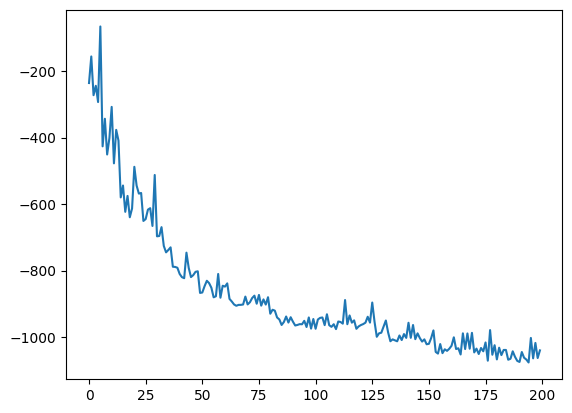

In [47]:
# construct SamplingVQE with callback
counts=[]
params=[]
values=[]
mddict=[]
optimizer = COBYLA(maxiter=200)
#var_form = EfficientSU2(qubitOp_tsp4.num_qubits, entanglement="full")
ry_clb = TwoLocal(qubitOp_tsp4.num_qubits, 'ry', "cz", reps=2, entanglement="linear")
vqe_clb = SamplingVQE(sampler=Sampler(), ansatz=ry_clb, optimizer=optimizer, callback=store_intermediate_result)
# run SamplingVQE
result_clb = vqe_clb.compute_minimum_eigenvalue(qubitOp_tsp4)
pylab.plot( values)
print("energy:", result_clb.eigenvalue.real)
print("time:", result_clb.optimizer_time)
x_clb = tsp4.sample_most_likely(result_clb.eigenstate)
print("feasible:", qp_tsp4.is_feasible(x_clb))
if  qp_tsp4.is_feasible(x_clb)==True:
    z_clb = tsp4.interpret(x_clb)
    print("solution:", z_clb)
    print("solution objective:", tsp4.tsp_value(z_clb, adj_matrix1))

energy: -1111.6806514055106
time: 3010.5903437137604
feasible: False


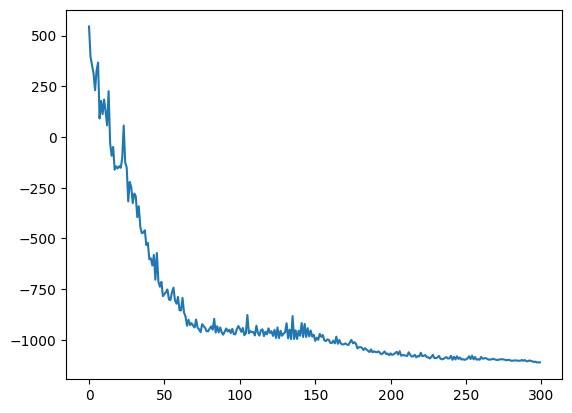

In [48]:
# construct SamplingVQE with callback
counts=[]
params=[]
values=[]
mddict=[]
optimizer = COBYLA(maxiter=300)
#var_form = EfficientSU2(qubitOp_tsp4.num_qubits, entanglement="full")
ry_clb = TwoLocal(qubitOp_tsp4.num_qubits, 'ry', "cz", reps=2, entanglement="linear")
vqe_clb = SamplingVQE(sampler=Sampler(), ansatz=ry_clb, optimizer=optimizer, callback=store_intermediate_result)
# run SamplingVQE
result_clb = vqe_clb.compute_minimum_eigenvalue(qubitOp_tsp4)
pylab.plot( values)
print("energy:", result_clb.eigenvalue.real)
print("time:", result_clb.optimizer_time)
x_clb = tsp4.sample_most_likely(result_clb.eigenstate)
print("feasible:", qp_tsp4.is_feasible(x_clb))
if  qp_tsp4.is_feasible(x_clb)==True:
    z_clb = tsp4.interpret(x_clb)
    print("solution:", z_clb)
    print("solution objective:", tsp4.tsp_value(z_clb, adj_matrix1))

energy: -1305.4790689746642
time: 2207.7366189956665
feasible: True
solution: [2, 0, 3, 1]
solution objective: 8.0


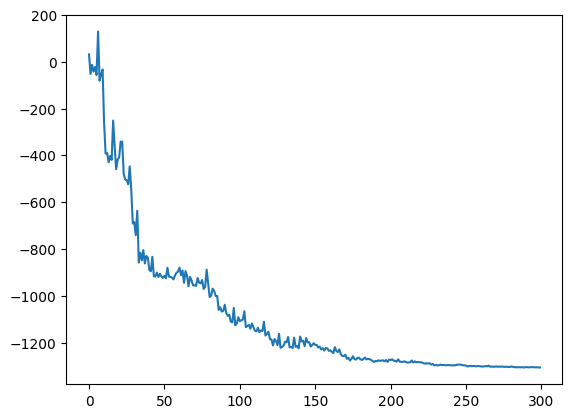

In [49]:
# construct SamplingVQE with callback
counts=[]
params=[]
values=[]
mddict=[]
optimizer = COBYLA(maxiter=300)
#var_form = EfficientSU2(qubitOp_tsp4.num_qubits, entanglement="full")
ry_clb = TwoLocal(qubitOp_tsp4.num_qubits, 'ry', "cz", reps=1, entanglement="linear")
vqe_clb = SamplingVQE(sampler=Sampler(), ansatz=ry_clb, optimizer=optimizer, callback=store_intermediate_result)
# run SamplingVQE
result_clb = vqe_clb.compute_minimum_eigenvalue(qubitOp_tsp4)
pylab.plot( values)
print("energy:", result_clb.eigenvalue.real)
print("time:", result_clb.optimizer_time)
x_clb = tsp4.sample_most_likely(result_clb.eigenstate)
print("feasible:", qp_tsp4.is_feasible(x_clb))
if  qp_tsp4.is_feasible(x_clb)==True:
    z_clb = tsp4.interpret(x_clb)
    print("solution:", z_clb)
    print("solution objective:", tsp4.tsp_value(z_clb, adj_matrix1))

energy: -1223.3840093191293
time: 1950.6236197948456
feasible: True
solution: [2, 0, 3, 1]
solution objective: 8.0


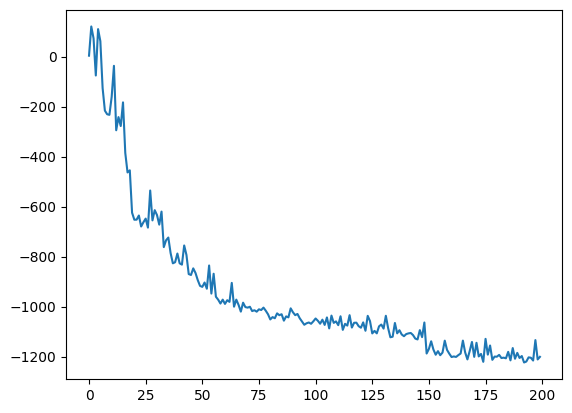

In [50]:
# construct SamplingVQE with callback
counts=[]
params=[]
values=[]
mddict=[]
optimizer = COBYLA(maxiter=200, tol=0.5)
#var_form = EfficientSU2(qubitOp_tsp4.num_qubits, entanglement="full")
ry_clb = TwoLocal(qubitOp_tsp4.num_qubits, 'ry', "cz", reps=2, entanglement="linear")
vqe_clb = SamplingVQE(sampler=Sampler(), ansatz=ry_clb, optimizer=optimizer, callback=store_intermediate_result)
# run SamplingVQE
result_clb = vqe_clb.compute_minimum_eigenvalue(qubitOp_tsp4)
pylab.plot( values)
print("energy:", result_clb.eigenvalue.real)
print("time:", result_clb.optimizer_time)
x_clb = tsp4.sample_most_likely(result_clb.eigenstate)
print("feasible:", qp_tsp4.is_feasible(x_clb))
if  qp_tsp4.is_feasible(x_clb)==True:
    z_clb = tsp4.interpret(x_clb)
    print("solution:", z_clb)
    print("solution objective:", tsp4.tsp_value(z_clb, adj_matrix1))

energy: -1083.281016661819
time: 2002.863923549652
feasible: False


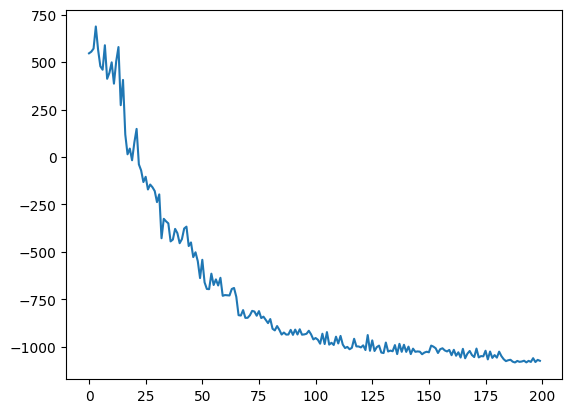

In [51]:
# construct SamplingVQE with callback
counts=[]
params=[]
values=[]
mddict=[]
optimizer = COBYLA(maxiter=200, tol=0.5)
#var_form = EfficientSU2(qubitOp_tsp4.num_qubits, entanglement="full")
ry_clb = TwoLocal(qubitOp_tsp4.num_qubits, 'ry', "cz", reps=2, entanglement="linear")
vqe_clb = SamplingVQE(sampler=Sampler(), ansatz=ry_clb, optimizer=optimizer, callback=store_intermediate_result)
# run SamplingVQE
result_clb = vqe_clb.compute_minimum_eigenvalue(qubitOp_tsp4)
pylab.plot( values)
print("energy:", result_clb.eigenvalue.real)
print("time:", result_clb.optimizer_time)
x_clb = tsp4.sample_most_likely(result_clb.eigenstate)
print("feasible:", qp_tsp4.is_feasible(x_clb))
if  qp_tsp4.is_feasible(x_clb)==True:
    z_clb = tsp4.interpret(x_clb)
    print("solution:", z_clb)
    print("solution objective:", tsp4.tsp_value(z_clb, adj_matrix1))

energy: -1287.1343258988018
time: 2964.8258657455444
feasible: True
solution: [0, 2, 1, 3]
solution objective: 8.0


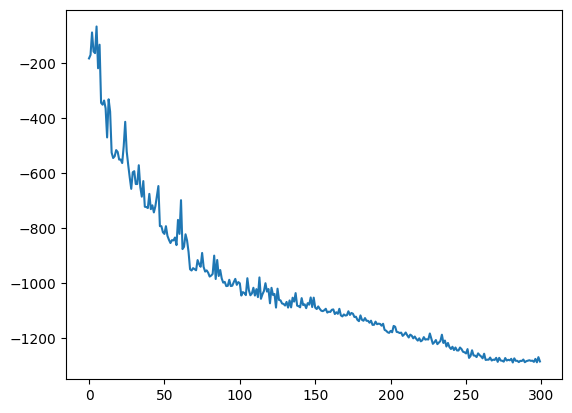

In [52]:
# construct SamplingVQE with callback
counts=[]
params=[]
values=[]
mddict=[]
optimizer = COBYLA(maxiter=300)
#var_form = EfficientSU2(qubitOp_tsp4.num_qubits, entanglement="full")
ry_clb = TwoLocal(qubitOp_tsp4.num_qubits, 'ry', "cz", reps=2, entanglement="linear")
vqe_clb = SamplingVQE(sampler=Sampler(), ansatz=ry_clb, optimizer=optimizer, callback=store_intermediate_result)
# run SamplingVQE
result_clb = vqe_clb.compute_minimum_eigenvalue(qubitOp_tsp4)
pylab.plot( values)
print("energy:", result_clb.eigenvalue.real)
print("time:", result_clb.optimizer_time)
x_clb = tsp4.sample_most_likely(result_clb.eigenstate)
print("feasible:", qp_tsp4.is_feasible(x_clb))
if  qp_tsp4.is_feasible(x_clb)==True:
    z_clb = tsp4.interpret(x_clb)
    print("solution:", z_clb)
    print("solution objective:", tsp4.tsp_value(z_clb, adj_matrix1))